In [1]:
# Install transformers from the PR branch until it's merged!
!pip install -q -U git+https://github.com/baptiste-aubertin/transformers.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, LightOnOCRForConditionalGeneration
import requests
from io import BytesIO

# Load Model
model_id = "lightonai/LightOnOCR-1B-1025"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = LightOnOCRForConditionalGeneration.from_pretrained(model_id, dtype=torch.bfloat16, device_map=device, attn_implementation="sdpa")
model.eval();

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using a model of type mistral3 to instantiate a model of type lightonocr. This is not supported for all configurations of models and can yield errors.


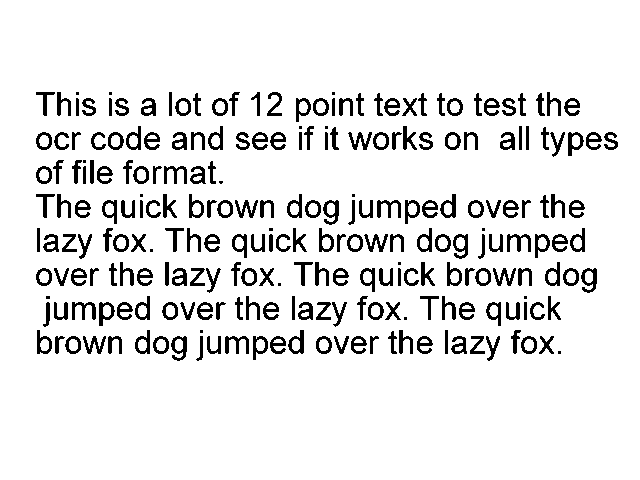


This is a lot of 12 point text to test the ocr code and see if it works on all types of file format.
The quick brown dog jumped over the lazy fox. The quick brown dog jumped over the lazy fox. The quick brown dog jumped over the lazy fox. The quick brown dog jumped over the lazy fox.


In [3]:
# Get a test image
image_url = "https://jeroen.github.io/images/testocr.png"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

display(image)

# Run inference
messages = [{"role": "user", "content": [{"type": "image"}]}]
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(text=[text], images=[image], return_tensors="pt").to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

outputs = model.generate(
    **inputs,
    max_new_tokens=1024,
)

input_length = inputs['input_ids'].shape[1]
generated_text = processor.tokenizer.decode(outputs[0, input_length:], skip_special_tokens=True)

print("============\n")
print(generated_text)